In [1]:
import pandas as pd
import numpy as np
from fractions import Fraction
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Import Data

In [2]:
commits = pd.read_csv("../inputs-outputs/commits.csv")
commits.dropna(inplace=True, axis=0)
commits

/tmp/ipykernel_11718/1239614662.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  commits = pd.read_csv("../inputs-outputs/commits.csv")


,PathFile,Commit hash,Commit timestamp,Subject
0,packages/react-components/react-checkbox/src/c...,4fad4cbbcbdb48847857c388135a3abda472add7,1679697439,fix: Fix vertical alignment of inline Checkbox...
1,apps/perf-test/package.json,3aa69e30ab692d4ea8335815cd6302636cdf9ba3,1679696710,applying package updates
2,apps/public-docsite-resources/package.json,3aa69e30ab692d4ea8335815cd6302636cdf9ba3,1679696710,applying package updates
3,apps/public-docsite-v9/package.json,3aa69e30ab692d4ea8335815cd6302636cdf9ba3,1679696710,applying package updates
4,apps/public-docsite/package.json,3aa69e30ab692d4ea8335815cd6302636cdf9ba3,1679696710,applying package updates
...,...,...,...,...
796661,src/app/pages/pages.module.ts,ed658566b3f15f402b10bf9b44cc02921eb9653f,1492183858,refator(@theme): add menu transclusion in one-...
796662,src/app/app.component.scss,d82d691681ca97e4764f75b9eada308518d795c8,1492161459,chore: base layout
796663,src/app/app.component.ts,d82d691681ca97e4764f75b9eada308518d795c8,1492161459,chore: base layout
796664,src/app/app.module.ts,d82d691681ca97e4764f75b9eada308518d795c8,1492161459,chore: base layout


In [3]:
metrics = pd.read_csv("../inputs-outputs/metrics.csv")
metrics.dropna(inplace=True, axis=0)
metrics

,Class,PathFile,Attributes,Methods,LOC,NOC,fanOut,WMC,LCOM
0,Optional,/home/school/MGL843/repos/code-server/src/node...,0.0,1.0,4.0,1.0,0.0,-1.0,0
1,ConfigArgs,/home/school/MGL843/repos/code-server/src/node...,1.0,0.0,4.0,1.0,1.0,0.0,0
2,CodeServer,/home/school/MGL843/repos/code-server/test/e2e...,3.0,6.0,186.0,9.0,0.0,5.0,(5/6)
3,WebsocketRouter,/home/school/MGL843/repos/code-server/src/node...,1.0,1.0,24.0,2.0,0.0,1.0,0
4,ChildProcess,/home/school/MGL843/repos/code-server/src/node...,1.0,4.0,54.0,5.0,3.0,5.0,1
...,...,...,...,...,...,...,...,...,...
1276,ResolverOptions,/home/school/MGL843/repos/react-hook-form/src/...,4.0,0.0,7.0,4.0,0.0,0.0,0
1277,Base,/home/school/MGL843/repos/react-hook-form/src/...,4.0,0.0,6.0,4.0,0.0,0.0,0
1278,File,/home/school/MGL843/repos/react-hook-form/src/...,2.0,0.0,5.0,2.0,0.0,0.0,0
1279,Nested,/home/school/MGL843/repos/react-hook-form/src/...,1.0,0.0,4.0,1.0,0.0,0.0,0


In [4]:
projects = pd.read_csv("../inputs-outputs/models/repo_list.csv")
projects

,Project,Source,Model
0,fluentui,/home/school/MGL843/repos/fluentui,/home/school/MGL843/inputs-outputs/models/flue...
1,ant-design,/home/school/MGL843/repos/ant-design,/home/school/MGL843/inputs-outputs/models/ant-...
2,utopia,/home/school/MGL843/repos/utopia,/home/school/MGL843/inputs-outputs/models/utop...
3,berry,/home/school/MGL843/repos/berry,/home/school/MGL843/inputs-outputs/models/berr...
4,ts-proto,/home/school/MGL843/repos/ts-proto,/home/school/MGL843/inputs-outputs/models/ts-p...
5,next-auth,/home/school/MGL843/repos/next-auth,/home/school/MGL843/inputs-outputs/models/next...
6,superset,/home/school/MGL843/repos/superset,/home/school/MGL843/inputs-outputs/models/supe...
7,formatjs,/home/school/MGL843/repos/formatjs,/home/school/MGL843/inputs-outputs/models/form...
8,pxt,/home/school/MGL843/repos/pxt,/home/school/MGL843/inputs-outputs/models/pxt....
9,language-tools,/home/school/MGL843/repos/language-tools,/home/school/MGL843/inputs-outputs/models/lang...


# Preprocess Data

Let keep only commits fixing issues and get their frequency per file.

In [5]:
fix_commits = commits[commits["Subject"].str.contains("fix")]
fix_count = pd.DataFrame(fix_commits["PathFile"].value_counts())
fix_count.columns = ["FixCount"]
fix_count

,FixCount
package.json,1470
yarn.lock,708
src/packages/cli/package.json,378
src/packages/sdk/package.json,370
src/packages/engine-core/package.json,336
...,...
packages/client/components/MenuItemIcon.tsx,1
packages/client/components/MenuItemAvatar.tsx,1
packages/client/components/MeetingHelp/HelpMenuContent.tsx,1
superset-frontend/temporary_superset_ui/superset-ui/packages/superset-ui-chart/test/components/MockChartPlugins.tsx,1


Lets modify paths in the metrics data so that it matches the commit data.

In [6]:
for path in projects["Source"]:
    metrics["PathFile"] = metrics["PathFile"].str.removeprefix(path + '/')

metrics

,Class,PathFile,Attributes,Methods,LOC,NOC,fanOut,WMC,LCOM
0,Optional,src/node/cli.ts,0.0,1.0,4.0,1.0,0.0,-1.0,0
1,ConfigArgs,src/node/cli.ts,1.0,0.0,4.0,1.0,1.0,0.0,0
2,CodeServer,test/e2e/models/CodeServer.ts,3.0,6.0,186.0,9.0,0.0,5.0,(5/6)
3,WebsocketRouter,src/node/wsRouter.ts,1.0,1.0,24.0,2.0,0.0,1.0,0
4,ChildProcess,src/node/wrapper.ts,1.0,4.0,54.0,5.0,3.0,5.0,1
...,...,...,...,...,...,...,...,...,...
1276,ResolverOptions,src/types/resolvers.ts,4.0,0.0,7.0,4.0,0.0,0.0,0
1277,Base,src/__typetest__/__fixtures__/traversable.ts,4.0,0.0,6.0,4.0,0.0,0.0,0
1278,File,src/types/utils.ts,2.0,0.0,5.0,2.0,0.0,0.0,0
1279,Nested,src/__typetest__/__fixtures__/traversable.ts,1.0,0.0,4.0,1.0,0.0,0.0,0


Lets assign all files to a single class by dropping all files containing more than one class. We can then use this column as the index.

In [7]:
metrics = metrics[metrics["PathFile"].duplicated() == False]
metrics

,Class,PathFile,Attributes,Methods,LOC,NOC,fanOut,WMC,LCOM
0,Optional,src/node/cli.ts,0.0,1.0,4.0,1.0,0.0,-1.0,0
2,CodeServer,test/e2e/models/CodeServer.ts,3.0,6.0,186.0,9.0,0.0,5.0,(5/6)
3,WebsocketRouter,src/node/wsRouter.ts,1.0,1.0,24.0,2.0,0.0,1.0,0
4,ChildProcess,src/node/wrapper.ts,1.0,4.0,54.0,5.0,3.0,5.0,1
6,OpenOptions,src/node/util.ts,3.0,0.0,6.0,3.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...
1267,ComponentToken,components/back-top/style/index.ts,1.0,0.0,4.0,1.0,0.0,0.0,0
1268,PaletteGenerators,components/theme/themes/shared/genColorMapToke...,2.0,0.0,5.0,2.0,0.0,0.0,0
1276,ResolverOptions,src/types/resolvers.ts,4.0,0.0,7.0,4.0,0.0,0.0,0
1277,Base,src/__typetest__/__fixtures__/traversable.ts,4.0,0.0,6.0,4.0,0.0,0.0,0


Let convert the LCOM column to float.

In [8]:
metrics["LCOM"] = metrics["LCOM"].str.strip("()").apply(Fraction).astype('float')
metrics.dtypes

metrics["LCOM"].value_counts()

/tmp/ipykernel_11718/3393612512.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics["LCOM"] = metrics["LCOM"].str.strip("()").apply(Fraction).astype('float')


0.000000    454
1.000000     16
0.500000      9
0.750000      5
0.833333      4
1.666667      3
1.250000      3
0.800000      3
1.400000      2
0.666667      2
1.333333      2
0.900000      2
1.200000      1
0.942105      1
0.875000      1
0.982143      1
0.964286      1
0.886364      1
0.857143      1
0.966667      1
1.027778      1
1.750000      1
1.500000      1
0.914286      1
0.920000      1
0.708333      1
1.041667      1
1.076923      1
0.791667      1
0.928571      1
0.916667      1
0.850000      1
0.700000      1
1.875000      1
Name: LCOM, dtype: int64

## Join the datasets

Lets associate each class to the the number of time it has been fixed. 

In [9]:
joined_data = metrics.join(fix_count, on="PathFile")
joined_data["FixCount"] = joined_data["FixCount"].fillna(0)
joined_data

,Class,PathFile,Attributes,Methods,LOC,NOC,fanOut,WMC,LCOM,FixCount
0,Optional,src/node/cli.ts,0.0,1.0,4.0,1.0,0.0,-1.0,0.000000,4.0
2,CodeServer,test/e2e/models/CodeServer.ts,3.0,6.0,186.0,9.0,0.0,5.0,0.833333,5.0
3,WebsocketRouter,src/node/wsRouter.ts,1.0,1.0,24.0,2.0,0.0,1.0,0.000000,0.0
4,ChildProcess,src/node/wrapper.ts,1.0,4.0,54.0,5.0,3.0,5.0,1.000000,4.0
6,OpenOptions,src/node/util.ts,3.0,0.0,6.0,3.0,0.0,0.0,0.000000,9.0
...,...,...,...,...,...,...,...,...,...,...
1267,ComponentToken,components/back-top/style/index.ts,1.0,0.0,4.0,1.0,0.0,0.0,0.000000,0.0
1268,PaletteGenerators,components/theme/themes/shared/genColorMapToke...,2.0,0.0,5.0,2.0,0.0,0.0,0.000000,3.0
1276,ResolverOptions,src/types/resolvers.ts,4.0,0.0,7.0,4.0,0.0,0.0,0.000000,2.0
1277,Base,src/__typetest__/__fixtures__/traversable.ts,4.0,0.0,6.0,4.0,0.0,0.0,0.000000,0.0


## Create the Dataset
Lets define the dependent variables as `X` and the independent variable as `y` where `0` denotes that no bug has been found and `1` denotes that at least one bug has been found.

In [39]:
X = joined_data[["Attributes", "Methods", "LOC", "NOC", "fanOut", "WMC", "LCOM"]]
y = (joined_data["FixCount"] > 0).astype(int)

None of the dependent variables seem to have a normal distribution (shown below). We must either normalize them or use a model that does not assume a normal distribution.

array([[<AxesSubplot:title={'center':'Attributes'}>,
        <AxesSubplot:title={'center':'Methods'}>,
        <AxesSubplot:title={'center':'LOC'}>],
       [<AxesSubplot:title={'center':'NOC'}>,
        <AxesSubplot:title={'center':'fanOut'}>,
        <AxesSubplot:title={'center':'WMC'}>],
       [<AxesSubplot:title={'center':'LCOM'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

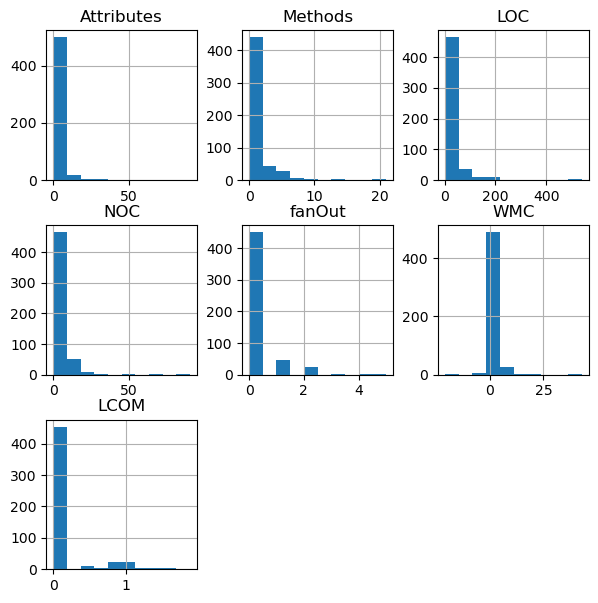

In [40]:
X.hist(figsize=(7,7))

Next lets verify the assumption that the dependent variables are independent of each other.

In [41]:
X.corr(method='spearman')

,Attributes,Methods,LOC,NOC,fanOut,WMC,LCOM
Attributes,1.000000,0.110982,0.414712,0.845586,0.161087,0.206597,0.331351
Methods,0.110982,1.000000,0.624538,0.539934,0.558917,0.594269,0.686805
LOC,0.414712,0.624538,1.000000,0.638656,0.371920,0.577478,0.549436
NOC,0.845586,0.539934,0.638656,1.000000,0.359510,0.421891,0.515459
fanOut,0.161087,0.558917,0.371920,0.359510,1.000000,0.381937,0.489121
WMC,0.206597,0.594269,0.577478,0.421891,0.381937,1.000000,0.679379
LCOM,0.331351,0.686805,0.549436,0.515459,0.489121,0.679379,1.000000


The `Attributes` and `NOC` data have a correlation above 0.75. We will drop the `NOC` feature to maintain the independence of dependent variables.

In [42]:
X.drop("NOC", axis=1, inplace=True)

/tmp/ipykernel_11718/680616481.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop("NOC", axis=1, inplace=True)


# Model
We will use a logistic regression model for the following reasons:
- the dependent variables aren't normal, and
- the independent variable is binary.

In [43]:
logit_model = LogisticRegression(random_state=1, fit_intercept=False, solver='lbfgs')
logit_model.fit(X, y)

y_mean = y / len(y)
y_pred = logit_model.predict_proba(X)[:,1]